In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Obtain the imdb review dataset from tensorflow datasets
dataset = tfds.load('imdb_reviews', as_supervised=True)

# Seperate test and train datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Split the test and train data into batches of 32
# and shuffling the training set
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVPZRCD/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVPZRCD/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVPZRCD/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])


Text:
 b'I should explain why i gave this..."piece of art" 1 star rating out of possible 10. Simply because it\'s hard or next to impossible to rate it unbiased. probably it would have been the same if i had given it 10/10 - explanations anyway would have followed.<br /><br />I am not fond of these pointless gore movies like HOSTEL or so - i think that\'s disgusting and pretty terrible (in all the possible contextual meanings), but as i found out after watching this movie - there is a genre called "historical drama" - and probably it would have been the case of 10/10 as it has plenty of it and Tarantino would have been more than happier with it (and made Kill Bill 3 to spill even more blood on screen than here to show that it is possible). but the thing about "historical drama" genre is that it\'s a sub-category of the "trash movies" where John Romero is the undead-gory-emperor-of-the-guts and so automatically it can\'t be rated as your default movie - as these are movies that are made

In [ ]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, _: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)


original:  b'I should explain why i gave this..."piece of art" 1 star rating out of possible 10. Simply because it\'s hard or next to impossible to rate it unbiased. probably it would have been the same if i had given it 10/10 - explanations anyway would have followed.<br /><br />I am not fond of these pointless gore movies like HOSTEL or so - i think that\'s disgusting and pretty terrible (in all the possible contextual meanings), but as i found out after watching this movie - there is a genre called "historical drama" - and probably it would have been the case of 10/10 as it has plenty of it and Tarantino would have been more than happier with it (and made Kill Bill 3 to spill even more blood on screen than here to show that it is possible). but the thing about "historical drama" genre is that it\'s a sub-category of the "trash movies" where John Romero is the undead-gory-emperor-of-the-guts and so automatically it can\'t be rated as your default movie - as these are movies that are 

In [ ]:
# Creating the model
model = tf.keras.Sequential([
	encoder,
	tf.keras.layers.Embedding(
		len(encoder.get_vocabulary()), 64, mask_zero=True),
	tf.keras.layers.Bidirectional(
		tf.keras.layers.LSTM(64, return_sequences=True)),
	tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
	tf.keras.layers.Dense(64, activation='relu'),
	tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
# Training the model and validating it on test set
history = model.fit(
	train_dataset,
	epochs=5,
	validation_data=test_dataset,
)


Epoch 1/5
782/782 [==============================] - 237s 270ms/step - loss: 0.4030 - accuracy: 0.8015 - val_loss: 0.3175 - val_accuracy: 0.8676
Epoch 2/5
782/782 [==============================] - 135s 172ms/step - loss: 0.2215 - accuracy: 0.9113 - val_loss: 0.3013 - val_accuracy: 0.8706
Epoch 3/5
782/782 [==============================] - 117s 149ms/step - loss: 0.1471 - accuracy: 0.9424 - val_loss: 0.3440 - val_accuracy: 0.8582
Epoch 4/5
782/782 [==============================] - 111s 141ms/step - loss: 0.0896 - accuracy: 0.9676 - val_loss: 0.4726 - val_accuracy: 0.8552
Epoch 5/5
782/782 [==============================] - 107s 137ms/step - loss: 0.0603 - accuracy: 0.9781 - val_loss: 0.5406 - val_accuracy: 0.8621


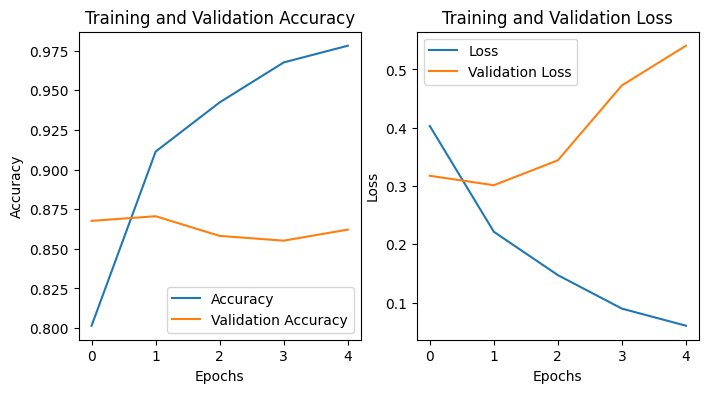

In [ ]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()


In [ ]:
# Making predictions
sample_text = (
	'''The movie by Subhash Pal was so good and the animation are so dope.
	I would recommend my friends to watch it.'''
)
def review(sample_text):
  predictions = model.predict(np.array([sample_text]))
  print(*predictions[0])
  # Print the label based on the prediction
  if predictions[0] > 0:
    print('The review is positive')
  else:
    print('The review is negative')

review(sample_text)

sample_text = (
	'''The movie by Subhash Pal was so bad and the animation are so wiered.
	I would not recommend my friends to watch it.'''
)

review(sample_text)

1/1 [==============================] - 0s 26ms/step
3.4687765
The review is positive
1/1 [==============================] - 0s 22ms/step
-1.9779074
The review is negative
